In [17]:
import sys
!{sys.executable} -m pip install tqdm


  Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)


You should consider upgrading via the 'c:\Users\Asus\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [1]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense, Dropout, GlobalMaxPooling1D, Attention
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
# Define paths
base_path = "scenefake"
train_path = os.path.join(base_path, "train")
dev_path = os.path.join(base_path, "dev")
eval_path = os.path.join(base_path, "eval")

# Data Augmentation

def add_noise(data, noise_factor=0.005):
    noise = np.random.randn(len(data))
    return data + noise_factor * noise 

def time_stretch(data, rate=1.1):
    return librosa.effects.time_stretch(data, rate)

def pitch_shift(data, sr, n_steps=2):
    return librosa.effects.pitch_shift(data, sr, n_steps)


In [3]:
# Feature Extraction

def extract_features(file_path, augment=False):
    y, sr = librosa.load(file_path, sr=16000)
    
    if augment:
        aug_choice = np.random.choice(['none', 'noise', 'stretch', 'pitch'])
        if aug_choice == 'noise':
            y = add_noise(y)
        elif aug_choice == 'stretch':
            y = time_stretch(y, rate=np.random.uniform(0.9, 1.2))
        elif aug_choice == 'pitch':
            y = pitch_shift(y, sr, n_steps=np.random.randint(-3, 3))
    
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T, axis=0)
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr))
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr))
    zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y))
    rmse = np.mean(librosa.feature.rms(y=y))
    
    features = np.hstack([mfccs, spectral_centroid, spectral_bandwidth, spectral_contrast, spectral_rolloff, chroma, zero_crossing_rate, rmse])
    return features


In [7]:
def load_dataset(base_path, subset):
    X, y = [], []
    
    real_path = os.path.join(base_path, subset, "real")
    fake_path = os.path.join(base_path, subset, "fake")
    
    fake_files = [file for file in os.listdir(fake_path) if file.endswith(".wav")]
    real_files = [file for file in os.listdir(real_path) if file.endswith(".wav")]
    
    min_files = min(len(fake_files), len(real_files))
    print(f"Processing {min_files} 'fake' and {min_files} 'real' audio files for balance in {subset} set")
    
    for file_name in tqdm(fake_files[:min_files], desc=f"{subset} Fake files", unit="file"):
        file_path = os.path.join(fake_path, file_name)
        X.append(extract_features(file_path))
        y.append(1)
    
    for file_name in tqdm(real_files[:min_files], desc=f"{subset} Real files", unit="file"):
        file_path = os.path.join(real_path, file_name)
        X.append(extract_features(file_path))
        y.append(0)
    
    return np.array(X), np.array(y)

X_train, y_train = load_dataset(base_path, "train")
X_dev, y_dev = load_dataset(base_path, "dev")
X_eval, y_eval = load_dataset(base_path, "eval")


Processing 2525 'fake' and 2525 'real' audio files for balance in train set


train Fake files:   0%|          | 0/2525 [00:00<?, ?file/s]

train Real files: 100%|██████████| 2525/2525 [01:42<00:00, 24.66file/s]


Processing 2548 'fake' and 2548 'real' audio files for balance in dev set


dev Real files: 100%|██████████| 2548/2548 [01:39<00:00, 25.51file/s]


Processing 6334 'fake' and 6334 'real' audio files for balance in eval set


eval Real files: 100%|██████████| 6334/6334 [03:24<00:00, 31.03file/s]


In [8]:
import numpy as np

# Save datasets
np.save("X_train.npy", X_train)
np.save("y_train.npy", y_train)
np.save("X_dev.npy", X_dev)
np.save("y_dev.npy", y_dev)
np.save("X_eval.npy", X_eval)
np.save("y_eval.npy", y_eval)

print("Datasets saved successfully!")


Datasets saved successfully!


In [9]:
import numpy as np

# Load datasets
X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")
X_dev = np.load("X_dev.npy")
y_dev = np.load("y_dev.npy")
X_eval = np.load("X_eval.npy")
y_eval = np.load("y_eval.npy")

print("Datasets loaded successfully!")


Datasets loaded successfully!


C:\Users\Asus\AppData\Local\Temp\ipykernel_15908\402430223.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_labels, y=class_counts, palette='viridis')


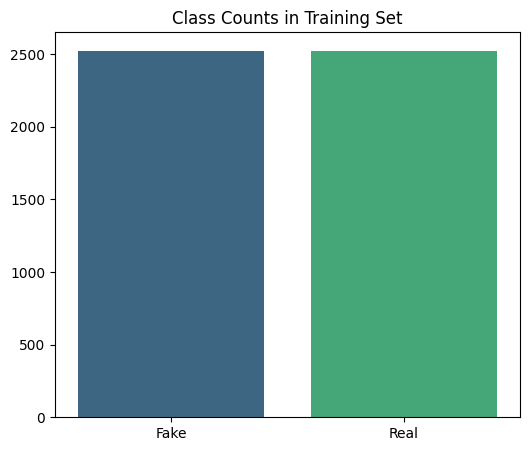

In [10]:
# Data Visualization
class_labels = ["Fake", "Real"]
class_counts = [sum(y_train), len(y_train) - sum(y_train)]

plt.figure(figsize=(6, 5))
sns.barplot(x=class_labels, y=class_counts, palette='viridis')
plt.title('Class Counts in Training Set')
plt.show()

In [11]:

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)


In [34]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Bidirectional, Attention, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def build_model(input_shape):
    inputs = Input(shape=input_shape)
    
    # Convolutional Feature Extractor
    x = Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)  # Normalization for stability
    x = MaxPooling1D(pool_size=2)(x)

    x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))(x)
    x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))(x)

    attention = Attention()([x, x])
    attention = GlobalMaxPooling1D()(attention)

    x = Dense(256, activation='relu')(attention)
    x = Dropout(0.4)(x)  # Prevent overfitting
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x)

    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    return model


input_shape = (X_train.shape[1], X_train.shape[2])

model = build_model(input_shape)

optimizer_updated = Adam(learning_rate=0.0005)

model.compile(optimizer=optimizer_updated, loss="binary_crossentropy", metrics=["accuracy"])

model.summary()

history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, verbose=1)


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 20, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 20, 128)   │        512 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 128)   │        512 │ conv1d_10[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_10    │ (None, 10, 128)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_16    │ (None, 10, 128)   │     98,816 │ max_pooling1d_10… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_17    │ (None, 10, 128)   │     98,816 │ bidirectional_16… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_10        │ (None, 10, 128)   │          0 │ bidirectional_17… │
│ (Attention)         │                   │            │ bidirectional_17… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ attention_10[0][… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 256)       │     33,024 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 256)       │          0 │ dense_26[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 128)       │     32,896 │ dropout_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 128)       │          0 │ dense_27[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 1)         │        129 │ dropout_17[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 264,705 (1.01 MB)

 Trainable params: 264,449 (1.01 MB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - accuracy: 0.5375 - loss: 0.6799 - val_accuracy: 0.7215 - val_loss: 0.5064
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.7136 - loss: 0.5311 - val_accuracy: 0.7946 - val_loss: 0.4357
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.7528 - loss: 0.4848 - val_accuracy: 0.7748 - val_loss: 0.4200
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7772 - loss: 0.4438 - val_accuracy: 0.7995 - val_loss: 0.3906
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7796 - loss: 0.4255 - val_accuracy: 0.7834 - val_loss: 0.3883
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.7752 - loss: 0.4242 - val_accuracy: 0.7995 - val_loss: 0.3637
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8020 - loss: 0.3896 - val_accuracy: 0.7871 - val_loss: 0.3671
Epoch 8/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8301 - loss: 0.3480 - val_accuracy: 0

In [35]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = (model.predict(X_test) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy*100:.2f}%")

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step
Model Accuracy: 95.25%


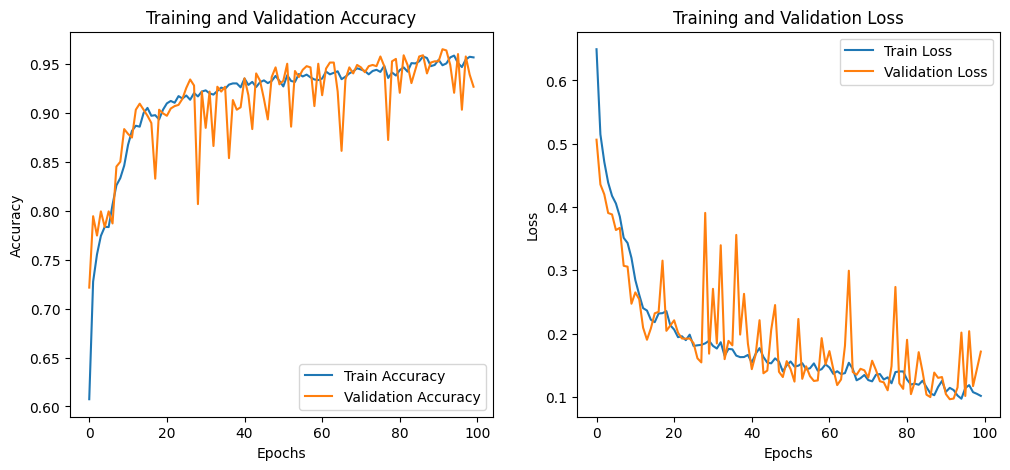

In [36]:
plt.figure(figsize=(12, 5))

# First subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Second subplot for loss
plt.subplot(1, 2, 2)  # Change this from (1, 2, 1) to (1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [37]:
model.save("my_model.h5")


In [39]:
import os

# Check if the file exists for .h5 format
print("HDF5 model saved:", os.path.exists("my_model.h5"))

# Check if the folder exists for TensorFlow SavedModel format
print("SavedModel exists:", os.path.exists("my_model"))


HDF5 model saved: True
SavedModel exists: False
